 Setup & Data Loading

In [17]:
# Import all required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('textile_production_cost_dataset.csv')
print("Dataset loaded successfully!")
print(f"Shape: {df.shape}")
display(df.head(3))

Dataset loaded successfully!
Shape: (153000, 10)


,Product_type,Brand,fabric,fabric_raw_cost,manufacturing_and_labour,transportation,tax,brand_value,retailer_margin,selling_price
0,Formal Shirt,Jackson-Pittman (mid_range),cotton,286.50,184.69,31.36,63.06,414.31,1280.71,2260.63
1,Formal Shirt,Skinner LLC (mid_range),cotton,283.12,198.49,22.95,52.95,375.12,1449.54,2382.16
2,Formal Shirt,Carey Group Basics (budget),cotton,212.38,127.70,23.84,45.88,99.40,380.19,889.39


Feature Engineering

In [18]:
# Calculate total cost
df['total_cost'] = df['fabric_raw_cost'] + df['manufacturing_and_labour'] + df['transportation'] + df['tax'] + df['brand_value']

# Extract brand tier from Brand column
df['brand_tier'] = df['Brand'].str.extract(r'\((.*?)\)')

# Initialize LabelEncoder
le = LabelEncoder()

# Encode categorical features
df['fabric_encoded'] = le.fit_transform(df['fabric'])
df['brand_tier_encoded'] = le.fit_transform(df['brand_tier'])
df['product_type_encoded'] = le.fit_transform(df['Product_type'].str.split().str[0])

# Display encoded values
print("\nFabric Encoding:", dict(zip(le.classes_, le.transform(le.classes_))))
print("Brand Tier Encoding:", dict(zip(le.classes_, le.transform(le.classes_))))


Fabric Encoding: {'Bag': 0, 'Blanket': 1, 'Blouse': 2, 'Cardigan': 3, 'Casual': 4, 'Classic': 5, 'Coat': 6, 'Contemporary': 7, 'Dhoti': 8, 'Dress': 9, 'Dupatta': 10, 'Formal': 11, 'Gloves': 12, 'Hat': 13, 'Hoodie': 14, 'Jacket': 15, 'Jeans': 16, 'Kurta': 17, 'Lehenga': 18, 'Modern': 19, 'Overall': 20, 'Pants': 21, 'Salwar': 22, 'Saree': 23, 'Scarf': 24, 'Shawl': 25, 'Sherwani': 26, 'Shirt': 27, 'Shorts': 28, 'Skirt': 29, 'Socks': 30, 'Sweater': 31, 'Sweatshirt': 32, 'T-shirt': 33, 'Traditional': 34, 'Vest': 35, 'Vintage': 36}
Brand Tier Encoding: {'Bag': 0, 'Blanket': 1, 'Blouse': 2, 'Cardigan': 3, 'Casual': 4, 'Classic': 5, 'Coat': 6, 'Contemporary': 7, 'Dhoti': 8, 'Dress': 9, 'Dupatta': 10, 'Formal': 11, 'Gloves': 12, 'Hat': 13, 'Hoodie': 14, 'Jacket': 15, 'Jeans': 16, 'Kurta': 17, 'Lehenga': 18, 'Modern': 19, 'Overall': 20, 'Pants': 21, 'Salwar': 22, 'Saree': 23, 'Scarf': 24, 'Shawl': 25, 'Sherwani': 26, 'Shirt': 27, 'Shorts': 28, 'Skirt': 29, 'Socks': 30, 'Sweater': 31, 'Sweatshir

Data Visualization

C:\Users\vardh\AppData\Local\Temp\ipykernel_4808\3009143777.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='fabric', y='selling_price', data=df, palette='viridis')


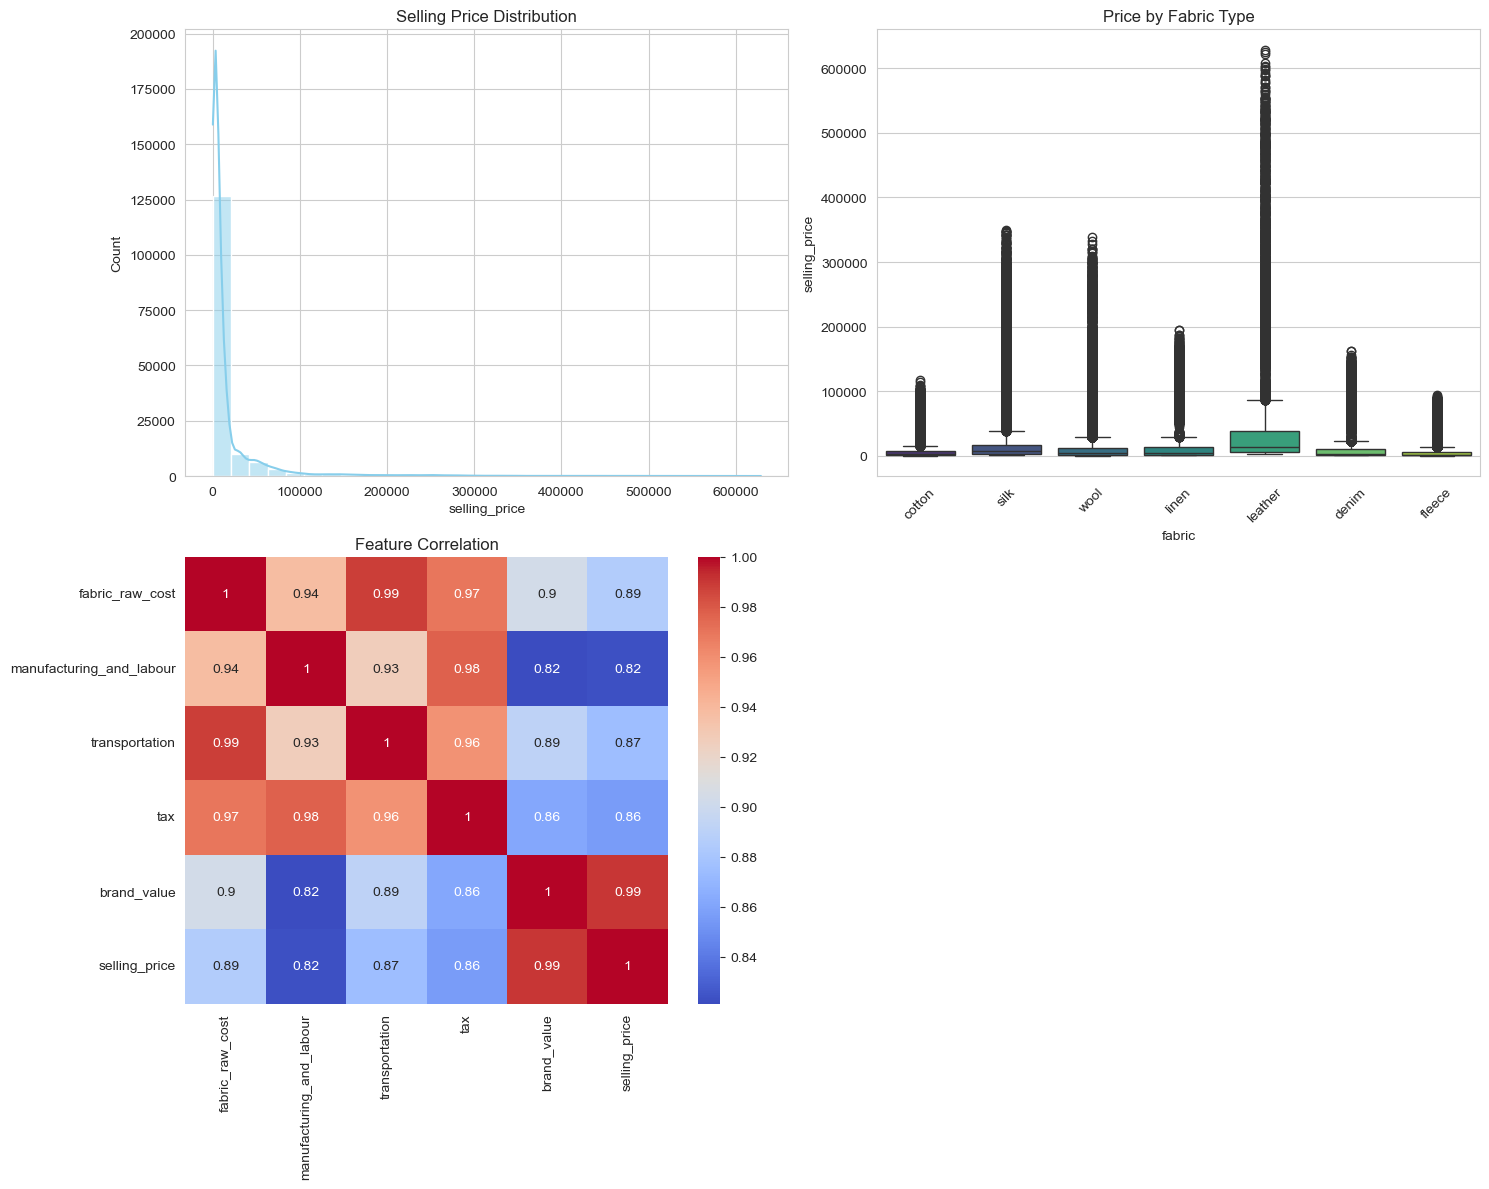

In [19]:
# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(15,12))

# Plot 1: Price Distribution
plt.subplot(2,2,1)
sns.histplot(df['selling_price'], bins=30, kde=True, color='skyblue')
plt.title("Selling Price Distribution")

# Plot 2: Price by Fabric Type
plt.subplot(2,2,2)
sns.boxplot(x='fabric', y='selling_price', data=df, palette='viridis')
plt.xticks(rotation=45)
plt.title("Price by Fabric Type")

# Plot 3: Feature Correlation
plt.subplot(2,2,3)
numeric_cols = ['fabric_raw_cost','manufacturing_and_labour','transportation','tax','brand_value','selling_price']
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation")

plt.tight_layout()
plt.show()

Model Training (XGBoost)

Model Performance:
- RMSE: 4826.63
- R² Score: 0.99


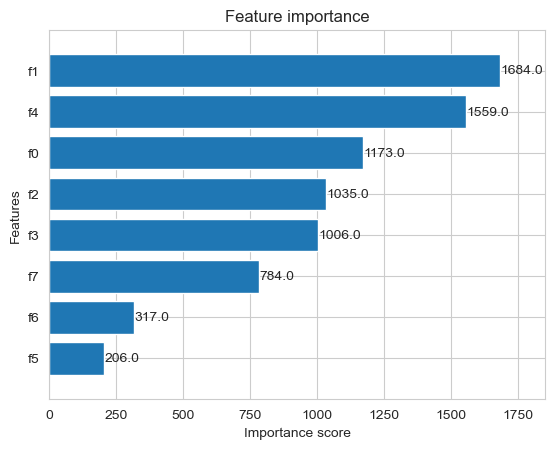

In [20]:
# Prepare features
features = ['fabric_raw_cost', 'manufacturing_and_labour', 'transportation', 
            'tax', 'brand_value', 'fabric_encoded', 'brand_tier_encoded', 
            'product_type_encoded']
X = df[features]
y = df['selling_price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators=150,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)
xgb_model.fit(X_train_scaled, y_train)

# Evaluate
y_pred = xgb_model.predict(X_test_scaled)
print(f"Model Performance:")
print(f"- RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"- R² Score: {r2_score(y_test, y_pred):.2f}")

# Feature importance
xgb.plot_importance(xgb_model, height=0.8)
plt.show()

SHAP Explainability

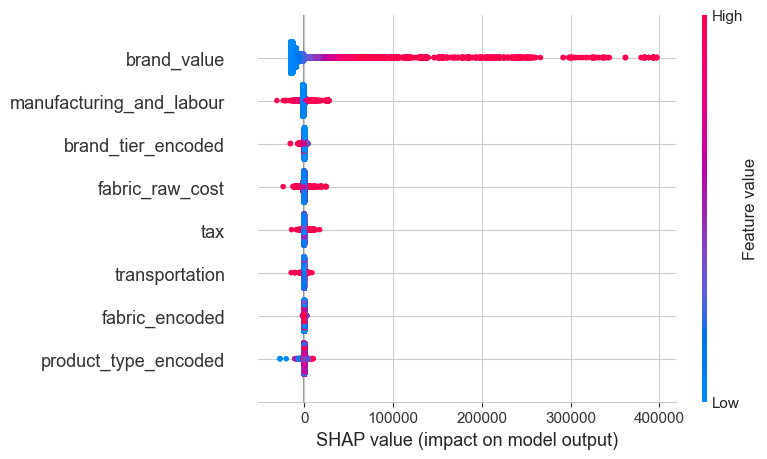

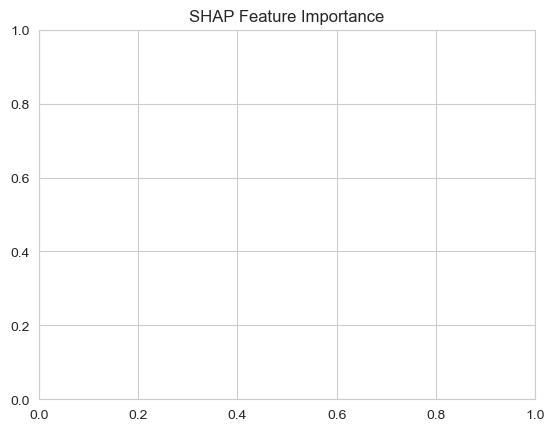

In [21]:
# SHAP analysis
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_scaled)

# Summary plot
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X_test_scaled, feature_names=features)
plt.title("SHAP Feature Importance")
plt.show()

In [24]:
import joblib
import numpy as np
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Sample training data - REPLACE WITH YOUR ACTUAL DATA
X_train = np.array([
    [1500, 800, 200, 300, 700, 1, 2, 42],  # silk, premium
    [500, 300, 50, 75, 200, 0, 0, 10]      # cotton, budget
])
y_train = np.array([3245.68, 1125.50])

# Initialize and fit scaler
scaler = StandardScaler()
scaler.fit(X_train)  # Important: Fit the scaler first

# Train model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(scaler.transform(X_train), y_train)

# Save everything needed
joblib.dump({
    'model': xgb_model,
    'scaler': scaler,  # Now properly fitted
    'fabric_types': ['cotton', 'silk', 'wool', 'linen', 'leather', 'denim', 'fleece'],
    'brand_tiers': ['budget', 'mid_range', 'premium', 'luxury']
}, 'textile_predictor_fixed.pkl')

print("Model and scaler saved successfully!")

Model and scaler saved successfully!
